# INSTALANDO PACOTES

In [122]:
import tensorflow as tf
import os

In [123]:
#EVITAR ERROS OOM (out of memory) CONFIGURANDO CONSUMO DE MEMORIA DA GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [124]:
# %pip install tensorflow

# REMOVENDO IMAGENS ERRADAS

In [125]:
import cv2
import imghdr
from matplotlib import pyplot as plt

In [126]:
data_dir = 'data'
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [127]:
# os.listdir(os.path.join(data_dir, 'happy'))

In [128]:
# img = cv2.imread(os.path.join('data', 'happy', '154006829.jpg'))
# img.shape

In [129]:
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
# plt.show()

APAGA TUDO Q N FOR DA EXTENSAO CERTA

In [130]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('A extensão do arquivo não está na lista:{}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Problema com a imagem {}'.format(image_path))

# CONFIGURANDO DADOS

In [131]:
import numpy as np
from matplotlib import pyplot as plt

FAZ COM QUE AS IMAGENS TENHAM UM PADRÃO 

In [132]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 423 files belonging to 2 classes.


In [133]:
data_iterator = data.as_numpy_iterator()

In [134]:
# CONSEGUIR MAIS UM BATCH DO ITERADOR
batch = data_iterator.next()

In [135]:
# IMAGENS REPRESENTADAS COMO ARRAYS
# batch[0].shape

In [136]:
scaled = batch[0] / 255

# PRE-PROCESSANDO DADOS

ESCALA DOS DADOS

In [137]:
data = data.map(lambda x,y: (x/255, y))


In [138]:
scaled_iterator = data.as_numpy_iterator()

In [139]:
batch = scaled_iterator.next()

In [140]:
batch[0].min()

0.0

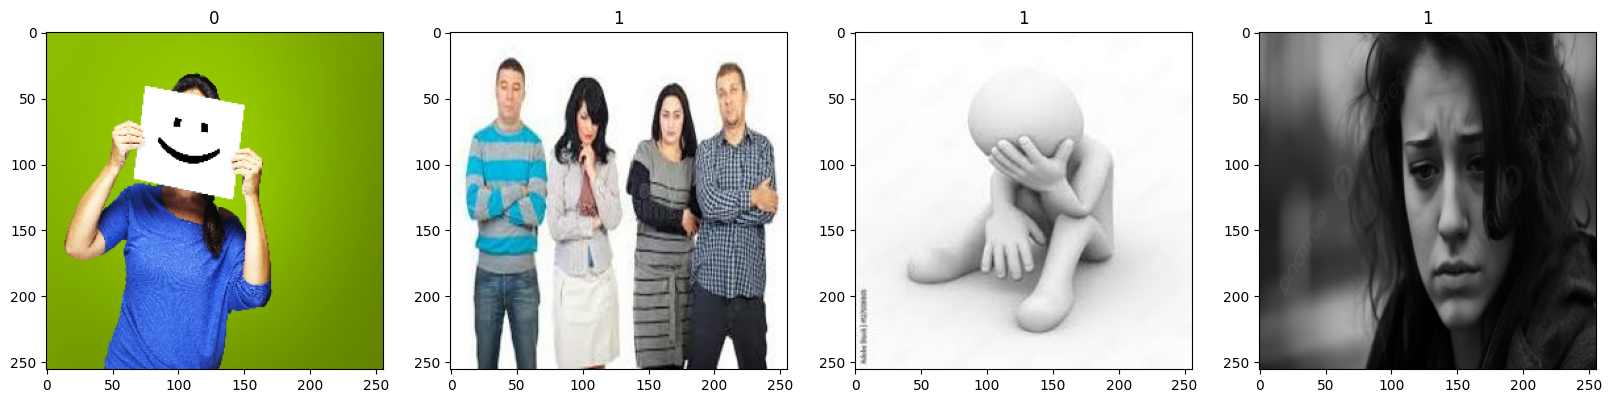

In [141]:
# 1 = SAD , 0 = HAPPY
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img) 
    ax[idx].title.set_text(batch[1][idx])

In [142]:
data.as_numpy_iterator().next() 

(array([[[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          ...,
          [2.35294122e-02, 2.35294122e-02, 2.35294122e-02],
          [2.35294122e-02, 2.35294122e-02, 2.35294122e-02],
          [2.35294122e-02, 2.35294122e-02, 2.35294122e-02]],
 
         [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          ...,
          [2.35294122e-02, 2.35294122e-02, 2.35294122e-02],
          [2.35294122e-02, 2.35294122e-02, 2.35294122e-02],
          [2.35294122e-02, 2.35294122e-02, 2.35294122e-02]],
 
         [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          ...,
          [2.35294122e-02, 2.35294122e-02, 2.3529

In [143]:
len(data)

14

In [144]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

In [145]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# DEEP MODEL

CONSTRUINDO O MODELO DEEP LEARNING

In [146]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [147]:
model = Sequential()

In [148]:
# 3 LAYERS CONVOLUCIONAIS
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

# JUNTA TUDO PRA 256 NEURONIOS E DPS PRA 1 SO (OUTPUT)
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [154]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [150]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 16)       

TREINO

In [151]:
logdir = 'logs'

In [152]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [155]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
9/9 [==============================] - 10s 873ms/step - loss: 0.8634 - accuracy: 0.5000 - val_loss: 0.6353 - val_accuracy: 0.6875
Epoch 2/20
9/9 [==============================] - 9s 843ms/step - loss: 0.6194 - accuracy: 0.6597 - val_loss: 0.5075 - val_accuracy: 0.8125
Epoch 3/20
9/9 [==============================] - 9s 849ms/step - loss: 0.4330 - accuracy: 0.8333 - val_loss: 0.3795 - val_accuracy: 0.8333
Epoch 4/20
9/9 [==============================] - 9s 848ms/step - loss: 0.3158 - accuracy: 0.8715 - val_loss: 0.2526 - val_accuracy: 0.8854
Epoch 5/20
9/9 [==============================] - 9s 861ms/step - loss: 0.2172 - accuracy: 0.9340 - val_loss: 0.1660 - val_accuracy: 0.9479
Epoch 6/20
9/9 [==============================] - 9s 857ms/step - loss: 0.1765 - accuracy: 0.9236 - val_loss: 0.0735 - val_accuracy: 0.9896
Epoch 7/20
9/9 [==============================] - 9s 860ms/step - loss: 0.1140 - accuracy: 0.9653 - val_loss: 0.0709 - val_accuracy: 0.9896
Epoch 8/20
9/9 [===

PERFORMANCE PLOT

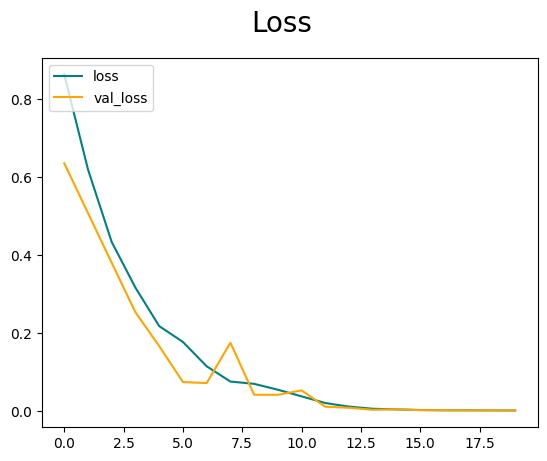

In [156]:
# SE LOSS DESCER E VAL LOSS SUBIR = OVERFITTING
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

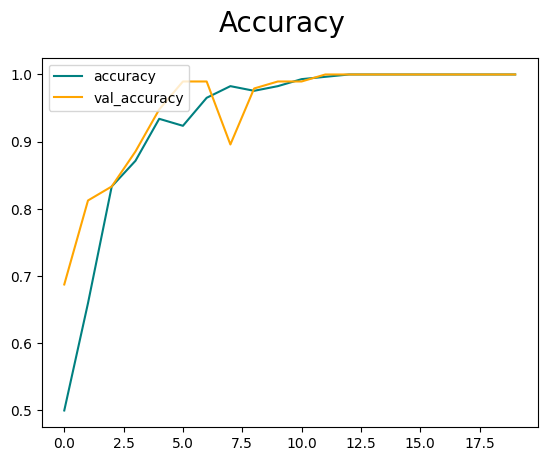

In [157]:
# 
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# AVALIAR A PERFORMANCE

AVALIAÇÃO

In [158]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [159]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [161]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 95ms/step


In [162]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:1.0, Recall:1.0, Accuracy:1.0


TESTANDO

In [ ]:
import cv2

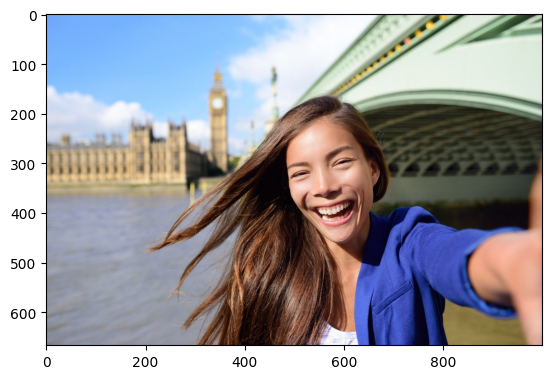

In [191]:
img = cv2.imread('feliz.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

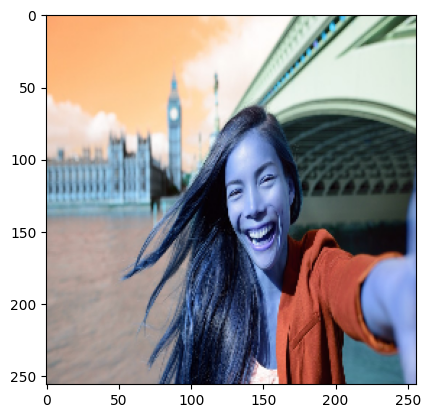

In [192]:
resize = tf.image.resize(img, (256, 256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [193]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 28ms/step


In [194]:
print(yhat)
if yhat > 0.5:
    print(f'Triste')
else:
    print(f'Feliz')

[[0.00032886]]
Feliz


# SALVAR MODELO

In [195]:
from tensorflow.keras.models import load_model
model.save(os.path.join('models', 'imageclassifiernewversionlive.h5')) 

c:\Users\nicol\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
